# Image Segmentation using Transformers
**Semantic Segmentation** is the task of classifying each pixel in an image. You can see it as a more precise way of classifying an image. It has a wide range of use cases in fields such as medical imaging and autonomous driving. As an example, for our pizza delivery robot, it is important to know exactly where the sidewalk is in an image, not just whether there is a sidewalk or not.

Because semantic segmentation is a type of classification, the network architectures that are used for image classification and semantic segmentation are very similar. In 2014, a seminal paper by Long et al. used convolutional neural networks for semantic segmentation. More recently, Transformers have been used for image classification (e.g. ViT), and now they're also being used for semantic segmentation, pushing the state-of-the-art further.

[SegFormer](https://arxiv.org/abs/2105.15203) is a model for semantic segmentation introduced by Xie et al in 2021. It has a hierarchical Transformer encoder that doesn't use positional encodings (in contrast to ViT) and a simple multi-layer perceptron decoder. SegFormer achieves state-of-the-art performance on multiple common datasets. Let's see how it performs for sidewalk images in our pizza delivery robot.

[Segformer Intro Video](https://youtu.be/hz3MO1j-wB4)

![Pizza Delivery](https://huggingface.co/blog/assets/56_fine_tune_segformer/pizza-scene.png)

In [ ]:
!nvidia-smi

Sat Oct  8 09:30:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [ ]:
!pip install -q evaluate transformers huggingface-hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


## Import Modules and Setup Hyperparameters

In [ ]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from evaluate import load
from datasets import load_dataset
from torchvision.transforms import ColorJitter, Normalize
from huggingface_hub import hf_hub_download

from transformers import (
    SegformerFeatureExtractor,
    SegformerForSemanticSegmentation,
    TrainingArguments,
    Trainer,
)

%matplotlib inline

## Build Data Pipeline

#### Load prepared dataset

[Dataset Link](https://huggingface.co/datasets/segments/sidewalk-semantic)

In [ ]:
dataset = "segments/sidewalk-semantic"
ds = load_dataset(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

#### Split training dataset into train and test

In [ ]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
val_ds = ds["test"]

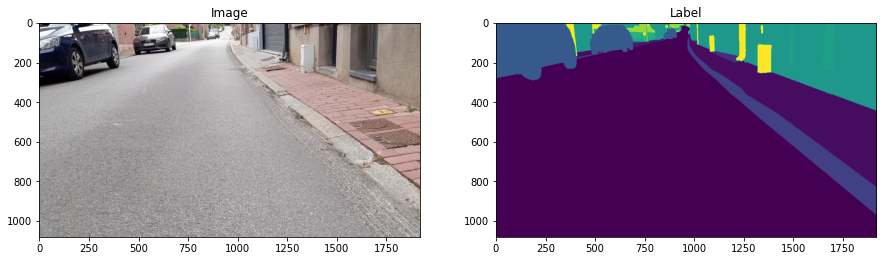

In [ ]:
# Preview 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))
ax1.imshow(train_ds[0]["pixel_values"])
ax1.set_title('Image')
ax2.imshow(train_ds[0]["label"])
ax2.set_title('Label')
plt.show()

#### Setup id to label, label to id maps

We'll extract the number of labels and the human-readable ids, so we can configure the segmentation model correctly later on.

In [ ]:
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=dataset, repo_type="dataset", filename=filename), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

#### Feature extractor & data augmentation

A SegFormer model expects the input to be of a certain shape. To transform our training data to match the expected shape, we can use `SegFormerFeatureExtractor`. We could use the `ds.map` function to apply the feature extractor to the whole training dataset in advance, but this can take up a lot of disk space. Instead, we'll use a *transform*, which will only prepare a batch of data when that data is actually used (on-the-fly). This way, we can start training without waiting for further data preprocessing.

In our transform, we'll also define some data augmentations to make our model more resilient to different lighting conditions. We'll use the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) function from `torchvision` to randomly change the brightness, contrast, saturation, and hue of the images in the batch.


In [ ]:
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 
feature_extractor = SegformerFeatureExtractor()

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [ ]:
# Preview the features of `train_ds`.
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

## Fine-tune Model


#### Build the model

Here, we'll load the largest SegFormer model (B5), pre-trained on ImageNet-1k.

In [ ]:
pretrained_model_name = "nvidia/mit-b5"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode

#### Set up the Trainer

First, we'll set up the `TrainingArguments`. This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [ ]:
epochs = 30
lr = 6e-5
batch_size = 10

hub_model_id = "zoheb/mit-b5-finetuned-sidewalk-semantic"

training_args = TrainingArguments(
    "mit-b5-finetuned-sidewalk-semantic",
    learning_rate=lr,
    optim="adamw_torch",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=2,
    evaluation_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=5,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the mean Intersection over Union (mIoU), directly accessible in the `datasets` library (see [here](https://huggingface.co/metrics/mean_iou)). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [ ]:
metric = load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric.compute(predictions=pred_labels, references=labels, 
                                   num_labels=num_labels, 
                                   ignore_index=0,
                                   reduce_labels=feature_extractor.reduce_labels)
    for key, value in metrics.items():
      if type(value) is np.ndarray:
        metrics[key] = value.tolist()
    return metrics

Finally, we can instantiate a `Trainer` object.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/zoheb/mit-b5-finetuned-sidewalk-semantic into local empty directory.


Download file tf_model.h5:   0%|          | 16.0k/324M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/324M [00:00<?, ?B/s]

## Train Model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
100,0.602300,0.646908,0.267316,0.333646,0.817424,"[nan, 0.6133545845476556, 0.8364090353329647, 0.38137509073939646, 0.5327993005339929, 0.23602577147233197, 0.0, 0.2940413798391027, 0.4409624127247189, 0.0, 0.82179506678366, 0.0, 0.0, 0.0, 0.0, 0.294043938756471, 0.0, nan, 0.6742025173820538, 0.0, 0.2569470434752603, 0.26380760865104447, 0.0, nan, 0.0, 0.23405130992710224, 0.0, 0.0, 0.8587120365599727, 0.7172835558558721, 0.9061715241986236, 0.0, 0.0, 0.19213056713551546, 0.0]","[nan, 0.6956333618058228, 0.9399694052668758, 0.4656031832157714, 0.8665882925562478, 0.2709195106618006, 0.0, 0.40097682194936846, 0.7534111240762349, 0.0, 0.9407586112068458, 0.0, 0.0, 0.0, 0.0, 0.30225168053401025, 0.0, nan, 0.8745788486342329, 0.0, 0.45872691430412776, 0.4017474344712073, 0.0, nan, 0.0, 0.2957993213552286, 0.0, 0.0, 0.9387068883578109, 0.8990974022143718, 0.9461773926455712, 0.0, 0.0, 0.2257327432509627, 0.0]"
200,0.454900,0.524257,0.308034,0.383182,0.845991,"[nan, 0.7121498800373828, 0.8605229730382099, 0.4155509991148017, 0.6705701518583478, 0.28474898502762197, 0.0, 0.4000005463200903, 0.5259823881795384, 0.0, 0.8534754491017964, 0.0, 0.0, 0.0, 0.0, 0.5229460710533042, 0.0, nan, 0.7252409376631832, 0.0, 0.34869196191405155, 0.3477438994451809, 0.0, nan, 0.0, 0.29494761716180257, 0.0, 0.0, 0.8692888266700605, 0.7609955741601468, 0.9227274283493206, 0.0, 0.020820960698689956, 0.3206977547376976, 0.0]","[nan, 0.7959722733913628, 0.9360401492693902, 0.7650009043226623, 0.7394570104786496, 0.494280141029327, 0.0, 0.5467906488715298, 0.7847919097627383, 0.0, 0.9544497559808356, 0.0, 0.0, 0.0, 0.0, 0.6925022328773562, 0.0, nan, 0.9105956631410885, 0.0, 0.4427035616576841, 0.49575640913465746, 0.0, nan, 0.0, 0.442213373178565, 0.0, 0.0, 0.9389759331271225, 0.8879368105926049, 0.9680653093133383, 0.0, 0.021146249733897865, 0.44516157499997017, 0.0]"
300,0.380400,0.515872,0.315387,0.380989,0.851003,"[nan, 0.6953576848752369, 0.8679098987294733, 0.3988795310355063, 0.7243967328672976, 0.2935916735971478, 0.0, 0.4317461514952529, 0.528230859393789, 0.0, 0.8722701118299208, 0.0, 0.0, 0.0, 0.0, 0.5480183955190797, 0.0, nan, 0.7339618441983061, 0.0, 0.34518920476495873, 0.34241390714097214, 0.0, nan, 0.0, 0.3446940133861753, 0.006010000246311486, 0.0, 0.8772379793102076, 0.7606582967504981, 0.9286394539490711, 0.0, 0.06614379535621326, 0.327037336065998, 0.0]","[nan, 0.7898366482239085, 0.9479392862038496, 0.4277844094773015, 0.8037346663152272, 0.5754641710950408, 0.0, 0.5235509867638012, 0.8115791520809024, 0.0, 0.9526809965053384, 0.0, 0.0, 0.0, 0.0, 0.6682743383631834, 0.0, nan, 0.9136704281673166, 0.0, 0.4276500767680342, 0.5125007812207042, 0.0, nan, 0.0, 0.5006244218883794, 0.006199974590268073, 0.0, 0.9296541537501175, 0.9079922984506656, 0.9647216668559461, 0.0, 0.07563608266117905, 0.4521464425116901, 0.0]"
400,0.343400,0.482292,0.343241,0.412934,0.864035,"[nan, 0.749387104803532, 0.8703641168440358, 0.48031306258200346, 0.6823170562213308, 0.40938161863222716, 0.0, 0.47177869183440213, 0.566756696313372, 0.0002746841132697398, 0.884592566844339, 0.07225226087372602, 0.0, 0.0, 0.0, 0.5671639036920033, 0.0, nan, 0.7407000313588046, 0.0, 0.3407475785240551, 0.34895311046406263, 0.0, nan, 0.02033321172321537, 0.36370170920551514, 0.3558062858610945, 0.0, 0.8841452733237299, 0.7767519415784561, 0.9319872325453658, 4.213678898220207e-05, 0.13463744784708506, 0.33133501352803824, 0.0]","[nan, 0.8488367256050677, 0.9371179008726709, 0.5694085729788388, 0.9256394526563614, 0.5399007622351745, 0.0, 0.5791450754227154, 0.7688448074679113, 0.0002746841132697398, 0.9452340816111515, 0.0724968192620688, 0.0, 0.0, 0.0, 0.7224227894514172, 0.0, nan, 0.902295855033859, 0.0, 0.4448897130834213, 0.5776283389372898, 0.0, nan, 0.02373381785146491, 0.5325791200190394, 0.4222843349002668, 0.0, 0.9442710745844469, 0.8835264182401082, 0.9724490

KeyboardInterrupt: ignored

We're done with training, we can push our fine-tuned model and the feature extractor to the Hugging Face hub.

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": dataset,
}

feature_extractor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

You can try manual upload too, if above doesn't works.

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj="/content/save_model/checkpoint-500/preprocessor_config.json",
    path_in_repo="preprocessor_config.json",
    repo_id="zoheb/mit-b5-finetuned-sidewalk-semantic",
    repo_type="model",
)

'https://huggingface.co/zoheb/mit-b5-finetuned-sidewalk-semantic/blob/main/preprocessor_config.json'

## Model Inference 

We'll first load the model from the hub using `SegformerForSemanticSegmentation.from_pretrained()`.

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained("zoheb/mit-b5-finetuned-sidewalk-semantic")
model = SegformerForSemanticSegmentation.from_pretrained("zoheb/mit-b5-finetuned-sidewalk-semantic")

Downloading:   0%|          | 0.00/272 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--zoheb--mit-b5-finetuned-sidewalk-semantic/snapshots/8b70c95850a30450f7baef36a262995bc0f0011a/preprocessor_config.json
Feature extractor SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 512
}



Downloading:   0%|          | 0.00/2.95k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--zoheb--mit-b5-finetuned-sidewalk-semantic/snapshots/8b70c95850a30450f7baef36a262995bc0f0011a/config.json
Model config SegformerConfig {
  "_name_or_path": "nvidia/mit-b5",
  "architectures": [
    "SegformerForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 768,
  "depths": [
    3,
    6,
    40,
    3
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    64,
    128,
    320,
    512
  ],
  "id2label": {
    "0": "unlabeled",
    "1": "flat-road",
    "2": "flat-sidewalk",
    "3": "flat-crosswalk",
    "4": "flat-cyclinglane",
    "5": "flat-parkingdriveway",
    "6": "flat-railtrack",
    "7": "flat-curb",
    "8": "human-person",
    "9": "human-rider",
    "10": "vehicle-car",
    "11": "vehicle-truck",
 

Downloading:   0%|          | 0.00/339M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--zoheb--mit-b5-finetuned-sidewalk-semantic/snapshots/8b70c95850a30450f7baef36a262995bc0f0011a/pytorch_model.bin
All model checkpoint weights were used when initializing SegformerForSemanticSegmentation.

All the weights of SegformerForSemanticSegmentation were initialized from the model checkpoint at zoheb/mit-b5-finetuned-sidewalk-semantic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use SegformerForSemanticSegmentation for predictions without further training.


Next, we'll load an image from our validation dataset. To segment this test image, we first need to prepare the image using the feature extractor. Then we forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [ ]:
n = 1
image = val_ds[n]['pixel_values']
gt_seg = val_ds[n]['labels']

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.shape[1:], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

Now it's time to display the result. The next cell defines the colors for each category, so that they match the "category coloring" on Segments Dataset.

In [ ]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

The next function overlays the output segmentation map on the original image.

In [ ]:
def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(sidewalk_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image).transpose(1, 2, 0) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

We'll display the result next to the actual image and ground-truth mask.

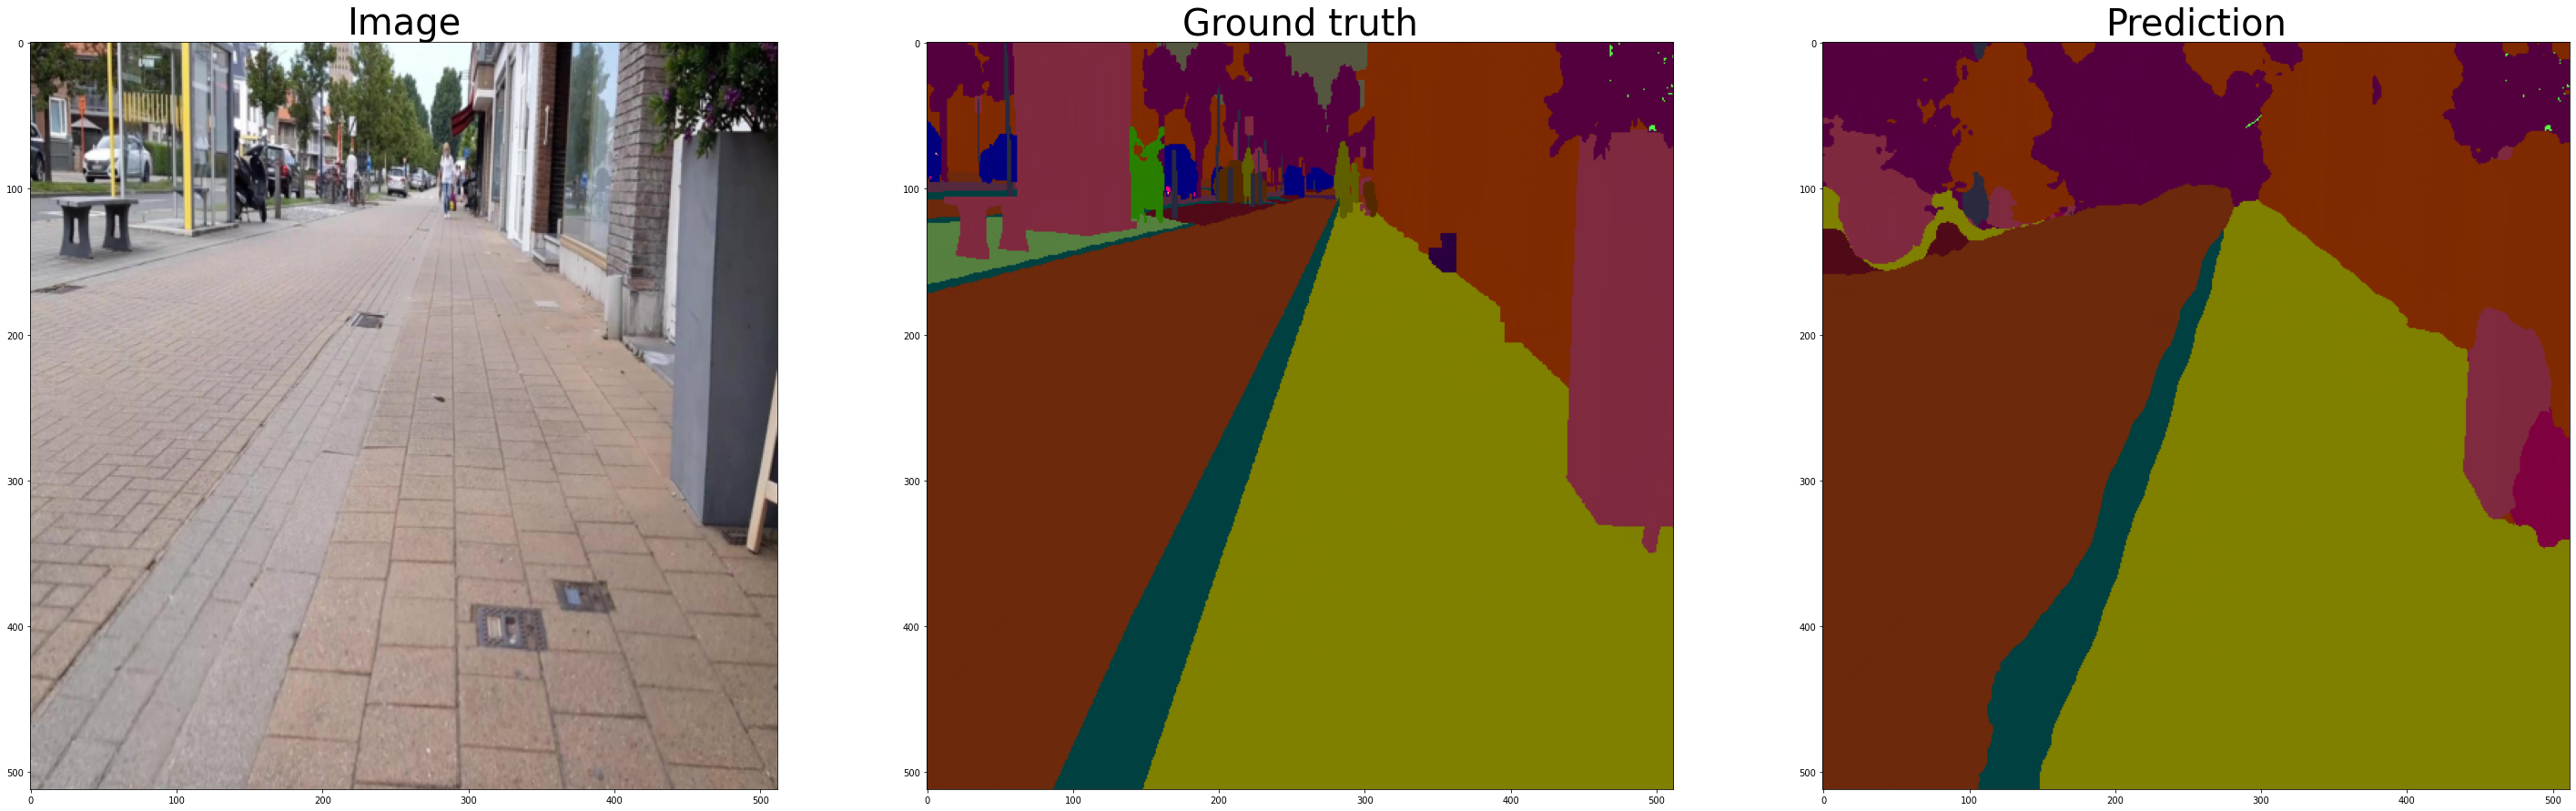

In [ ]:
# de-normalize the validation image
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225 ]

inv_normalize = Normalize(
   mean= [-m/s for m, s in zip(image_mean, image_std)],
   std= [1/s for s in image_std]
)
inv_tensor = inv_normalize(torch.from_numpy(image))
pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 3, figsize=(30,10))
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Image", {'fontsize': 40})
axs[0].imshow(inv_tensor.numpy().transpose(1, 2, 0))
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)
axs[2].set_title("Prediction", {'fontsize': 40})
axs[2].imshow(pred_img)

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. 

Check out [live application](https://huggingface.co/spaces/zoheb/yolos_demo).

**That's it! You now know how to create your own image segmentation dataset and how to use it to fine-tune a semantic segmentation model.**